# Regression

_For our analysis we will use_
* pandas 
* numpy  
* matplotlib 

_I'm interested about the link between age/weight and injury/recovery time_

In [778]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
pd.set_option('notebook_repr_html', True)

In [779]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import validation_curve
import datetime
import pycountry_convert as pc
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split as split
import warnings
from sys import modules
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split as split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, pairwise_distances
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler, LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_log_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score,r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score,r2_score
from sklearn.tree import DecisionTreeRegressor

## Load Final-playerTmp.txt file
Features are:
* PlayerId
* name
* club
* club_value
* birth
* weight
* height
* country : born state of the player
* role
* foot
* transfers : history of transfers
* injuries: history of injuries

In [780]:
tuples = []
i=0
for t in open('Final-playerTmp.txt'):
    i=i+1
    if i == 5087:
        tuples.append(eval(t[1:-1]))
    else:
        tuples.append(eval(t[1:-2]))
df = pd.DataFrame(tuples)
df.columns = ["id", "name", "club","club_value","birth","weight","height","country","role","foot","transfers","injuries"]
number_of_players = df.shape[0]
df.shape

(5087, 12)

In [781]:
df.head()

,id,name,club,club_value,birth,weight,height,country,role,foot,transfers,injuries
0,238223,Ederson,Manchester City,"1,14 Bill. €",1993-08-17,89,"1,88",Brazil,Goalkeeper,left,"[(\nBenfica , \nMan City , 17/18, Jul 1, 2017)...","[(16/17, Meniscal Injury, 29)]"
1,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...","[(18/19, Achilles tendon rupture, 314), (16/17..."
2,371021,Arijanet Murić,Manchester City,"1,14 Bill. €",1998-11-07,-,"1,98",Kosovo,Goalkeeper,right,"[(\nNAC Breda , \nMan City , 18/19, Aug 22, 20...",[]
3,186590,John Stones,Manchester City,"1,14 Bill. €",1994-05-28,69,"1,88",England,Defender - Centre-Back,right,"[(\nEverton , \nMan City , 16/17, Aug 9, 2016)...","[(18/19, Muscle Injury, 6), (17/18, Minor Knoc..."
4,176553,Aymeric Laporte,Manchester City,"1,14 Bill. €",1994-05-27,85,"1,91",France,Defender - Centre-Back,left,"[(\nAthletic , \nMan City , 17/18, Jan 30, 201...","[(18/19, Muscle Injury, 12), (16/17, Groin Inj..."


## Replace and manage values in DataFrame

#### During the analysis we will focus on injurie of player according to their age , so all the player that don't have info about the birth date will be remove 

In [782]:
df = df[df['birth'].notnull()]
number_of_new_players = df.shape[0]
df.shape

(4792, 12)

In [783]:
total_player = number_of_players-number_of_new_players
print(str(total_player) + " players removed")

295 players removed


#### Let's see what our dataframe talking about , what are the injuries ? 

In [784]:
injuries_list = [injurie[1] for injurie in df['injuries'].sum()]
s = pd.Series(injuries_list).value_counts()


#### What are the 5 main injuries ?

In [785]:
s[:15]

Unknown Injury               1944
Hamstring Injury             1104
Knee Injury                   845
Ankle Injury                  803
Muscle Injury                 786
Muscular problems             754
Thigh Problems                580
Knee Problems                 485
Knock                         410
Torn Muscle Fibre             410
Cruciate Ligament Rupture     346
Minor Knock                   345
Fitness                       330
Shoulder Injury               327
Groin Injury                  285
dtype: int64

#### currently each row is a player with a list of injuries , we will "flatten" it to get a row per injurie

In [786]:
s = df.apply(lambda x: pd.Series(x[11]),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'injurie'
df = df.drop('injuries', axis=1).join(s)
df.reset_index()
df.head()



,id,name,club,club_value,birth,weight,height,country,role,foot,transfers,injurie
0,238223,Ederson,Manchester City,"1,14 Bill. €",1993-08-17,89,"1,88",Brazil,Goalkeeper,left,"[(\nBenfica , \nMan City , 17/18, Jul 1, 2017)...","(16/17, Meniscal Injury, 29)"
1,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...","(18/19, Achilles tendon rupture, 314)"
1,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...","(16/17, Disrupted Calf Muscle, 57)"
1,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...","(15/16, Calf Injury, 17)"
1,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...","(15/16, Torn muscle bundle, 24)"


In [787]:
df.shape

(19884, 12)

In [788]:
df = df.reset_index(drop=True)
df.head(10)

,id,name,club,club_value,birth,weight,height,country,role,foot,transfers,injurie
0,238223,Ederson,Manchester City,"1,14 Bill. €",1993-08-17,89,"1,88",Brazil,Goalkeeper,left,"[(\nBenfica , \nMan City , 17/18, Jul 1, 2017)...","(16/17, Meniscal Injury, 29)"
1,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...","(18/19, Achilles tendon rupture, 314)"
2,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...","(16/17, Disrupted Calf Muscle, 57)"
3,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...","(15/16, Calf Injury, 17)"
4,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...","(15/16, Torn muscle bundle, 24)"
5,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...","(13/14, Torn Muscle Fibre, 10)"
6,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...","(12/13, Fractured Arm, 53)"
7,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...","(09/10, Ruptured intraarticular ligament initi..."
8,371021,Arijanet Murić,Manchester City,"1,14 Bill. €",1998-11-07,-,"1,98",Kosovo,Goalkeeper,right,"[(\nNAC Breda , \nMan City , 18/19, Aug 22, 20...",NaN
9,186590,John Stones,Manchester City,"1,14 Bill. €",1994-05-28,69,"1,88",England,Defender - Centre-Back,right,"[(\nEverton , \nMan City , 16/17, Aug 9, 2016)...","(18/19, Muscle Injury, 6)"


#### Need to remove all the player that don't have any injurie history

In [789]:
df = df[df['injurie'].notnull()]
df.shape

(18695, 12)

#### the injurie is currently describe as a tupple , I will create 3 new columns instead of injurie column :
* season of the injurie
* type of the injurie
* recovery time 

In [790]:
df_injurie = pd.DataFrame(df['injurie'].tolist(), index=df.index)
df_injurie.head()

,0,1,2
0,16/17,Meniscal Injury,29
1,18/19,Achilles tendon rupture,314
2,16/17,Disrupted Calf Muscle,57
3,15/16,Calf Injury,17
4,15/16,Torn muscle bundle,24


In [791]:
df = df.drop('injurie', axis=1).join(df_injurie)
df.head()

,id,name,club,club_value,birth,weight,height,country,role,foot,transfers,0,1,2
0,238223,Ederson,Manchester City,"1,14 Bill. €",1993-08-17,89,"1,88",Brazil,Goalkeeper,left,"[(\nBenfica , \nMan City , 17/18, Jul 1, 2017)...",16/17,Meniscal Injury,29
1,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...",18/19,Achilles tendon rupture,314
2,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...",16/17,Disrupted Calf Muscle,57
3,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...",15/16,Calf Injury,17
4,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...",15/16,Torn muscle bundle,24


In [792]:
df = df.rename(index=str, columns={0: "season", 1: "type" , 2 : "days"})
df.head()

,id,name,club,club_value,birth,weight,height,country,role,foot,transfers,season,type,days
0,238223,Ederson,Manchester City,"1,14 Bill. €",1993-08-17,89,"1,88",Brazil,Goalkeeper,left,"[(\nBenfica , \nMan City , 17/18, Jul 1, 2017)...",16/17,Meniscal Injury,29
1,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...",18/19,Achilles tendon rupture,314
2,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...",16/17,Disrupted Calf Muscle,57
3,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...",15/16,Calf Injury,17
4,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...",15/16,Torn muscle bundle,24


#### we will investigate the influence of the age on the injuries ,so, for each row , I add a new column " age " , the age of the player at the specific injurie

In [793]:
df.season = df.season.apply(lambda x : '20' + x[3:] + '-01-01')
df.head()

,id,name,club,club_value,birth,weight,height,country,role,foot,transfers,season,type,days
0,238223,Ederson,Manchester City,"1,14 Bill. €",1993-08-17,89,"1,88",Brazil,Goalkeeper,left,"[(\nBenfica , \nMan City , 17/18, Jul 1, 2017)...",2017-01-01,Meniscal Injury,29
1,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...",2019-01-01,Achilles tendon rupture,314
2,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...",2017-01-01,Disrupted Calf Muscle,57
3,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...",2016-01-01,Calf Injury,17
4,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...",2016-01-01,Torn muscle bundle,24


In [794]:
def injurie_age(season,birth):
    return datetime.datetime.strptime(season, '%Y-%m-%d').year - datetime.datetime.strptime(birth, '%Y-%m-%d').year


In [795]:
df['age'] = df.apply(lambda x : injurie_age(x['season'], x['birth']), axis=1)

In [796]:
df.head()

,id,name,club,club_value,birth,weight,height,country,role,foot,transfers,season,type,days,age
0,238223,Ederson,Manchester City,"1,14 Bill. €",1993-08-17,89,"1,88",Brazil,Goalkeeper,left,"[(\nBenfica , \nMan City , 17/18, Jul 1, 2017)...",2017-01-01,Meniscal Injury,29,24
1,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...",2019-01-01,Achilles tendon rupture,314,36
2,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...",2017-01-01,Disrupted Calf Muscle,57,34
3,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...",2016-01-01,Calf Injury,17,33
4,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...",2016-01-01,Torn muscle bundle,24,33


In [797]:
df = df[df['days'] != '?']
df["days"] = pd.to_numeric(df["days"])


In [798]:
df['club_value'] = df['club_value'].apply(lambda x : x.split(",")[0]).astype(int)

there is club like manchester city that the previous line will return 1 because it's billions and not millions so need to return it to 1000 millions

In [799]:
df['club_value'] = df['club_value'].apply(lambda x : 1000 if x == 1 else x).astype(int)

In [800]:
df.head()

,id,name,club,club_value,birth,weight,height,country,role,foot,transfers,season,type,days,age
0,238223,Ederson,Manchester City,1000,1993-08-17,89,"1,88",Brazil,Goalkeeper,left,"[(\nBenfica , \nMan City , 17/18, Jul 1, 2017)...",2017-01-01,Meniscal Injury,29,24
1,40423,Claudio Bravo,Manchester City,1000,1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...",2019-01-01,Achilles tendon rupture,314,36
2,40423,Claudio Bravo,Manchester City,1000,1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...",2017-01-01,Disrupted Calf Muscle,57,34
3,40423,Claudio Bravo,Manchester City,1000,1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...",2016-01-01,Calf Injury,17,33
4,40423,Claudio Bravo,Manchester City,1000,1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...",2016-01-01,Torn muscle bundle,24,33


Let's see the distribution to know how to categorize in equal sets

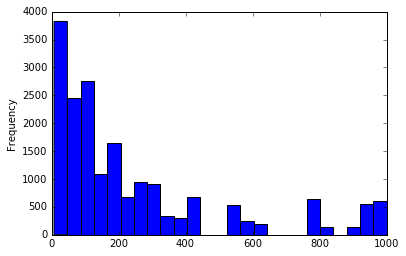

In [801]:
df['club_value'].plot(kind='hist',bins=25)

#### We can see that most of the club are under 320 millions

In [802]:
df.shape

(18691, 15)

#### We want to divide our data frame in 4 equals sets , we have about ~18691 injuries , so each group get 4600 injuries

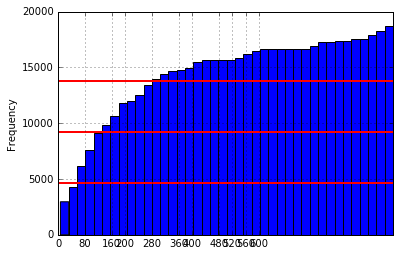

In [803]:
fig = plt.figure() # Create matplotlib figure

ax = fig.add_subplot(111)
df['club_value'].plot(kind='hist',bins=40,cumulative=True,ax=ax)
plt.plot([0,1000], [4600,4600], 'r-', lw=2)
plt.plot([0,1000], [9200,9200], 'r-', lw=2)
plt.plot([0,1000], [13800,13800], 'r-', lw=2)
plt.xticks([0,80,160,200,280,360,400,480,520,560,600])

plt.grid()

#### So we will separate the club by 6 categories :
* [0-60] millions : 1 
* [60-135] millions : 2 
* [135 -315] millions : 3
* [315 -1000] millions : 4

In [804]:
def club_to_category(value):
    if 0 < value <=  60 :
        return 1
    if 60 < value <= 135 :
        return 2
    if 135 < value <= 315 :
        return 3
    else :
        return 4

In [805]:
df['club_value'] = df['club_value'].apply(club_to_category)

In [806]:
df['club_value'].value_counts()

3    4842
2    4781
4    4537
1    4531
Name: club_value, dtype: int64

In [807]:
def fix_foot(foot):
    if foot in ["right","left","both"] :
        return foot
    return "both"

In [808]:
df['foot'] = df['foot'].apply(fix_foot)

In [809]:
df['foot'].value_counts()

right    13094
left      4518
both      1079
Name: foot, dtype: int64

In [810]:
df.head()

,id,name,club,club_value,birth,weight,height,country,role,foot,transfers,season,type,days,age
0,238223,Ederson,Manchester City,4,1993-08-17,89,"1,88",Brazil,Goalkeeper,left,"[(\nBenfica , \nMan City , 17/18, Jul 1, 2017)...",2017-01-01,Meniscal Injury,29,24
1,40423,Claudio Bravo,Manchester City,4,1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...",2019-01-01,Achilles tendon rupture,314,36
2,40423,Claudio Bravo,Manchester City,4,1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...",2017-01-01,Disrupted Calf Muscle,57,34
3,40423,Claudio Bravo,Manchester City,4,1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...",2016-01-01,Calf Injury,17,33
4,40423,Claudio Bravo,Manchester City,4,1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...",2016-01-01,Torn muscle bundle,24,33


In [811]:
countries = df['country'].unique().tolist()
len(countries)

113

In [812]:
def convert_country_to_continent(country):
    try:
        country_code = pc.country_name_to_country_alpha2(country, cn_name_format="default")
        continent_name = pc.country_alpha2_to_continent_code(country_code)
        return continent_name
    except:
        if(country in ["England","Kosovo","Wales","Scotland","Northern Ireland","Bosnia-Herzegovina","North Macedonia"]):
            return "EU"
        if(country in ["DR Congo","Cote d'Ivoire","The Gambia"]):
            return "AF"
        if(country =="Korea, South"):
            return "AS"
        if(country == "Curacao"):
            return "SA"
        return "ROW"

In [813]:
df['continent'] = df['country'].apply(convert_country_to_continent)

In [814]:
df['continent'].value_counts()

EU    13092
SA     2138
AF     1569
AS     1525
NA      301
OC       66
Name: continent, dtype: int64

In [815]:
df[df['continent'] == "ROW" ]

,id,name,club,club_value,birth,weight,height,country,role,foot,transfers,season,type,days,age,continent


In [816]:
df['role'].value_counts()

Defender - Centre-Back             3638
Forward - Centre-Forward           2557
Midfielder - Central Midfield      2392
Midfielder - Defensive Midfield    1633
Defender - Right-Back              1554
Defender - Left-Back               1527
Goalkeeper                         1296
Forward - Right Winger             1215
Forward - Left Winger              1190
Midfielder - Attacking Midfield    1054
Forward - Second Striker            271
Midfielder - Left Midfield          193
Midfielder - Right Midfield         171
Name: role, dtype: int64

In [817]:
def convert_to_main_role(value):
    try:
        return value.split("-")[0]
    except:
        return None

In [818]:
df['role'] = df['role'].apply(convert_to_main_role)
df.head()

,id,name,club,club_value,birth,weight,height,country,role,foot,transfers,season,type,days,age,continent
0,238223,Ederson,Manchester City,4,1993-08-17,89,"1,88",Brazil,Goalkeeper,left,"[(\nBenfica , \nMan City , 17/18, Jul 1, 2017)...",2017-01-01,Meniscal Injury,29,24,SA
1,40423,Claudio Bravo,Manchester City,4,1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...",2019-01-01,Achilles tendon rupture,314,36,SA
2,40423,Claudio Bravo,Manchester City,4,1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...",2017-01-01,Disrupted Calf Muscle,57,34,SA
3,40423,Claudio Bravo,Manchester City,4,1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...",2016-01-01,Calf Injury,17,33,SA
4,40423,Claudio Bravo,Manchester City,4,1983-04-13,84,"1,84",Chile,Goalkeeper,right,"[(\nFC Barcelona , \nMan City , 16/17, Aug 25,...",2016-01-01,Torn muscle bundle,24,33,SA


In [819]:
df.shape

(18691, 16)

In [820]:
df = df[df['type'].isin(["Knee Injury","Muscle Injury","Hamstring Injury","Ankle Injury"])]

In [821]:
df = df.reset_index(drop = True)

In [822]:
df.head()

,id,name,club,club_value,birth,weight,height,country,role,foot,transfers,season,type,days,age,continent
0,186590,John Stones,Manchester City,4,1994-05-28,69,"1,88",England,Defender,right,"[(\nEverton , \nMan City , 16/17, Aug 9, 2016)...",2019-01-01,Muscle Injury,6,25,EU
1,186590,John Stones,Manchester City,4,1994-05-28,69,"1,88",England,Defender,right,"[(\nEverton , \nMan City , 16/17, Aug 9, 2016)...",2018-01-01,Hamstring Injury,42,24,EU
2,186590,John Stones,Manchester City,4,1994-05-28,69,"1,88",England,Defender,right,"[(\nEverton , \nMan City , 16/17, Aug 9, 2016)...",2016-01-01,Knee Injury,24,22,EU
3,186590,John Stones,Manchester City,4,1994-05-28,69,"1,88",England,Defender,right,"[(\nEverton , \nMan City , 16/17, Aug 9, 2016)...",2015-01-01,Ankle Injury,66,21,EU
4,176553,Aymeric Laporte,Manchester City,4,1994-05-27,85,"1,91",France,Defender,left,"[(\nAthletic , \nMan City , 17/18, Jan 30, 201...",2019-01-01,Muscle Injury,12,25,EU


In [823]:
df.shape

(3537, 16)

In [824]:
df = df.drop(["id", "name", "club","birth","weight","country","transfers","season"], axis=1)

In [825]:
df.head()

,club_value,height,role,foot,type,days,age,continent
0,4,"1,88",Defender,right,Muscle Injury,6,25,EU
1,4,"1,88",Defender,right,Hamstring Injury,42,24,EU
2,4,"1,88",Defender,right,Knee Injury,24,22,EU
3,4,"1,88",Defender,right,Ankle Injury,66,21,EU
4,4,"1,91",Defender,left,Muscle Injury,12,25,EU


In [826]:
df.shape

(3537, 8)

In [827]:
df['continent'].value_counts()

EU    2555
SA     509
AF     298
AS     102
NA      54
OC      19
Name: continent, dtype: int64

#### need to merge some continent

In [828]:
def merge_continent(continent):
        if(continent in ["EU","NA"]):
            return "EU/NA"
        return "ROW"

In [829]:
df['continent'] = df['continent'].apply(merge_continent)

In [830]:
df.head()

,club_value,height,role,foot,type,days,age,continent
0,4,"1,88",Defender,right,Muscle Injury,6,25,EU/NA
1,4,"1,88",Defender,right,Hamstring Injury,42,24,EU/NA
2,4,"1,88",Defender,right,Knee Injury,24,22,EU/NA
3,4,"1,88",Defender,right,Ankle Injury,66,21,EU/NA
4,4,"1,91",Defender,left,Muscle Injury,12,25,EU/NA


In [831]:
df['continent'].value_counts()

EU/NA    2609
ROW       928
Name: continent, dtype: int64

In [832]:
df['club_value'].value_counts()

4    984
3    938
2    865
1    750
Name: club_value, dtype: int64

In [833]:
df['type'].value_counts()

Hamstring Injury    1104
Knee Injury          844
Ankle Injury         803
Muscle Injury        786
Name: type, dtype: int64

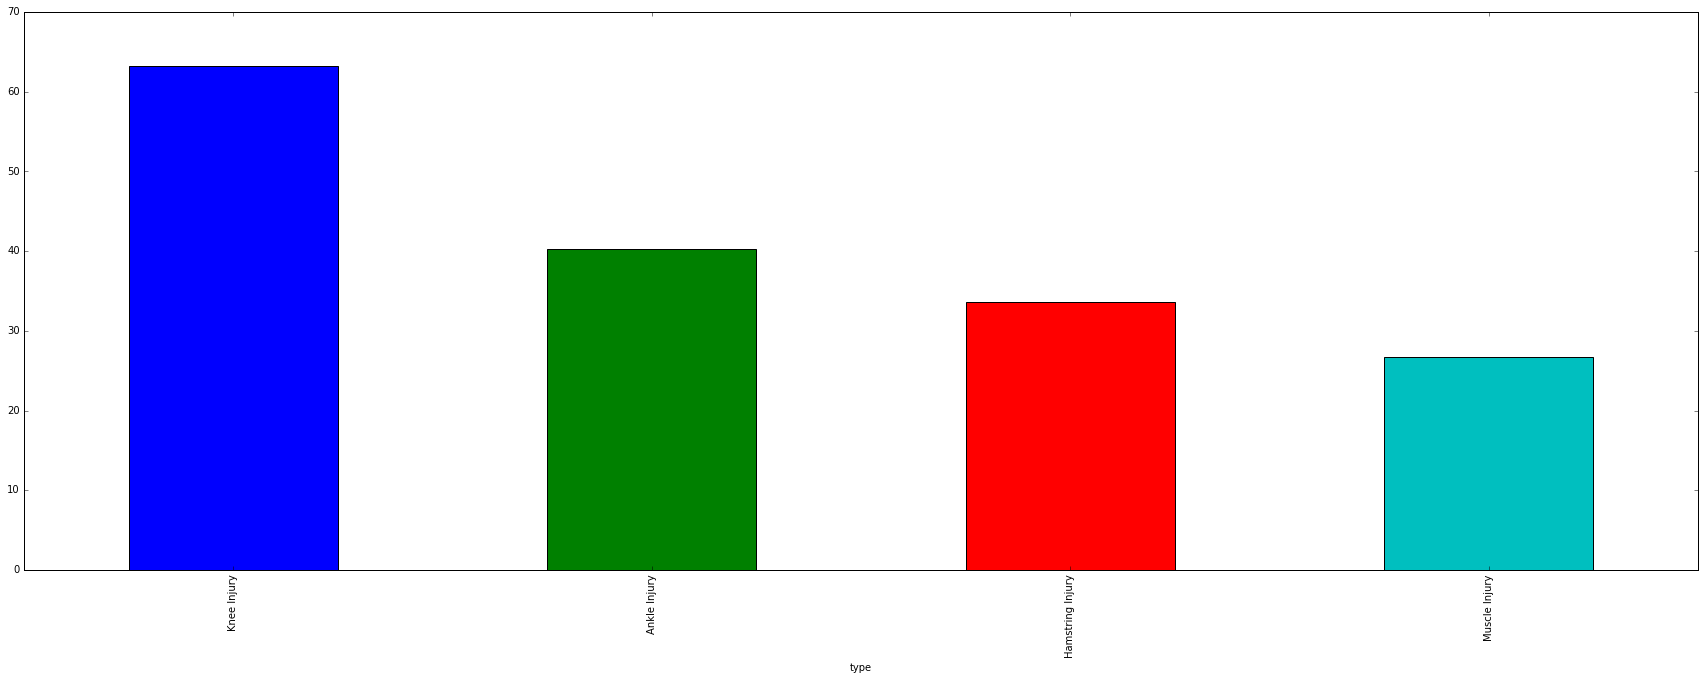

In [834]:
df.groupby('type')['days'].mean().sort_values(ascending=False)[:50].plot(kind='bar',figsize=(30,10))

#### remove outliers

##### Without remove outliers the error was Huge like 57 days on the train !!

In [835]:
df['index_col'] = df.index
df['index_col'] = df['index_col'].astype(int)
df.head()

,club_value,height,role,foot,type,days,age,continent,index_col
0,4,"1,88",Defender,right,Muscle Injury,6,25,EU/NA,0
1,4,"1,88",Defender,right,Hamstring Injury,42,24,EU/NA,1
2,4,"1,88",Defender,right,Knee Injury,24,22,EU/NA,2
3,4,"1,88",Defender,right,Ankle Injury,66,21,EU/NA,3
4,4,"1,91",Defender,left,Muscle Injury,12,25,EU/NA,4


In [836]:
type(df["index_col"][0])

numpy.int32

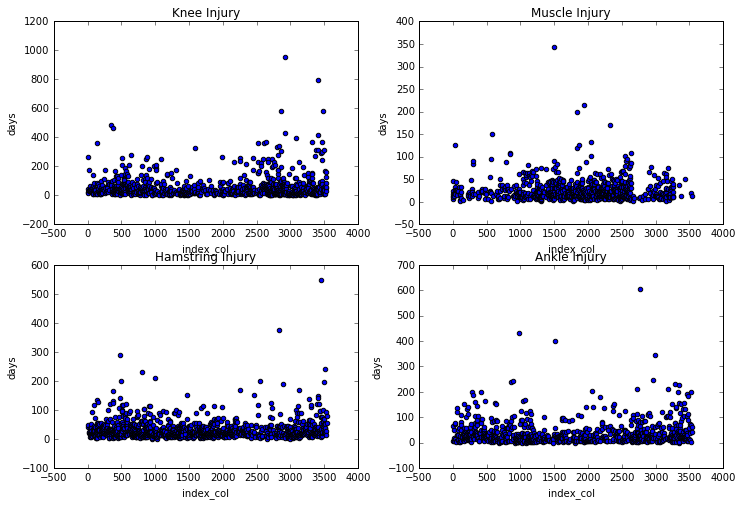

In [837]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
df[df["type"] == "Knee Injury"].plot.scatter(x ="index_col" , y="days",ax=axes[0,0],title="Knee Injury")
df[df["type"] == "Muscle Injury"].plot.scatter(x ="index_col" , y="days",ax=axes[0,1],title="Muscle Injury")
df[df["type"] == "Hamstring Injury"].plot.scatter(x ="index_col" , y="days",ax=axes[1,0],title="Hamstring Injury")
df[df["type"] == "Ankle Injury"].plot.scatter(x ="index_col" , y="days",ax=axes[1,1],title="Ankle Injury")

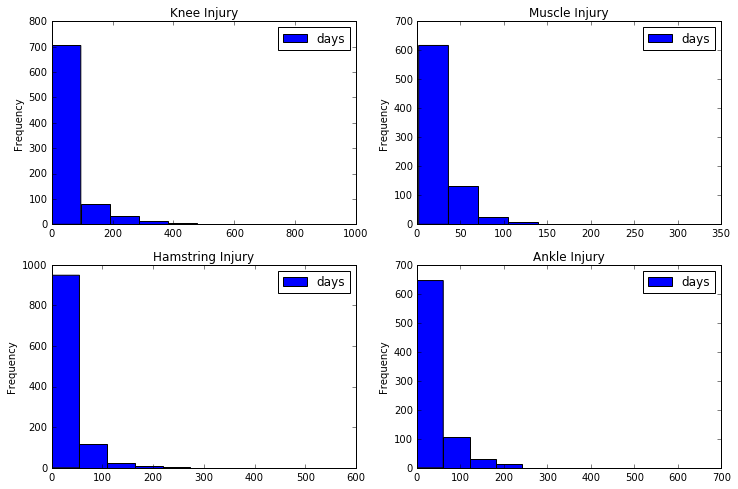

In [838]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
df[df["type"] == "Knee Injury"].plot.hist(x ="index_col" , y="days",ax=axes[0,0],title="Knee Injury")
df[df["type"] == "Muscle Injury"].plot.hist(x ="index_col" , y="days",ax=axes[0,1],title="Muscle Injury")
df[df["type"] == "Hamstring Injury"].plot.hist(x ="index_col" , y="days",ax=axes[1,0],title="Hamstring Injury")
df[df["type"] == "Ankle Injury"].plot.hist(x ="index_col" , y="days",ax=axes[1,1],title="Ankle Injury")

#### Need to calculate prediction with and without outliers

In [839]:
outliers_list = []

In [840]:
outliers_list.append(df.index[(df["type"] == "Muscle Injury") & (df["days"] > 145)].tolist())
outliers_list.append(df.index[(df["type"] == "Knee Injury") & (df["days"] > 550)].tolist())
outliers_list.append(df.index[(df["type"] == "Hamstring Injury") & (df["days"] > 250)].tolist())
outliers_list.append(df.index[(df["type"] == "Ankle Injury") & (df["days"] > 300)].tolist())

In [841]:
outliers_list

[[578L, 1500L, 1835L, 1935L, 2325L],
 [2868L, 2922L, 3406L, 3485L],
 [485L, 2824L, 3452L],
 [976L, 1517L, 2773L, 2997L]]

In [842]:
outliers_flat_list = []
for sublist in outliers_list:
    for item in sublist:
        outliers_flat_list.append(int(item))

In [843]:
df.drop(df.index[outliers_flat_list], inplace=True)

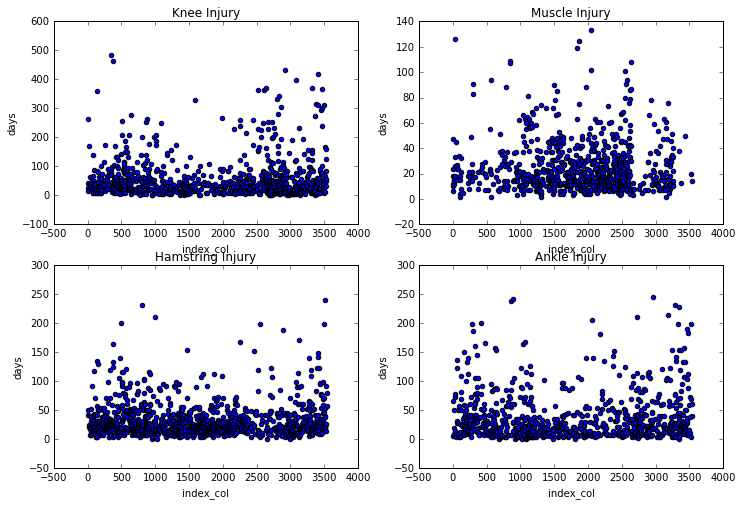

In [844]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
df[df["type"] == "Knee Injury"].plot.scatter(x ="index_col" , y="days",ax=axes[0,0],title="Knee Injury")
df[df["type"] == "Muscle Injury"].plot.scatter(x ="index_col" , y="days",ax=axes[0,1],title="Muscle Injury")
df[df["type"] == "Hamstring Injury"].plot.scatter(x ="index_col" , y="days",ax=axes[1,0],title="Hamstring Injury")
df[df["type"] == "Ankle Injury"].plot.scatter(x ="index_col" , y="days",ax=axes[1,1],title="Ankle Injury")

In [845]:
df.shape

(3521, 9)

In [846]:
df = df.drop(["index_col"], axis=1)

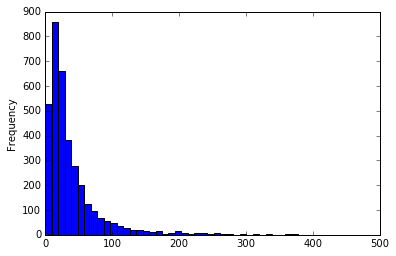

In [847]:
df['days'].plot(kind='hist',bins=50)

#### We see in the histogram that the data has not a good scattering so It will be difficult for models to catch the "far" point ( like 300 days etc etc ) 

In [848]:
#df = df[df['days'] < 126] 

#### Need to do mean it will be our start point (Our models has to be better than the error give by "mean"model)

In [849]:
average = df['days'].mean()

In [850]:
df['average'] = average

In [851]:
df.head()

,club_value,height,role,foot,type,days,age,continent,average
0,4,"1,88",Defender,right,Muscle Injury,6,25,EU/NA,38.89804
1,4,"1,88",Defender,right,Hamstring Injury,42,24,EU/NA,38.89804
2,4,"1,88",Defender,right,Knee Injury,24,22,EU/NA,38.89804
3,4,"1,88",Defender,right,Ankle Injury,66,21,EU/NA,38.89804
4,4,"1,91",Defender,left,Muscle Injury,12,25,EU/NA,38.89804


In [852]:
from sklearn.preprocessing import LabelEncoder
le_cols = []
df_scatter_matrix = df
for c in ["role","foot","continent","type"]:
    le = LabelEncoder()
    le.fit(df_scatter_matrix[c])
    le_cols.append(le)
    df_scatter_matrix[c] = le.transform(df_scatter_matrix[c])
df_scatter_matrix.head()

,club_value,height,role,foot,type,days,age,continent,average
0,4,"1,88",0,2,3,6,25,0,38.89804
1,4,"1,88",0,2,1,42,24,0,38.89804
2,4,"1,88",0,2,2,24,22,0,38.89804
3,4,"1,88",0,2,0,66,21,0,38.89804
4,4,"1,91",0,1,3,12,25,0,38.89804


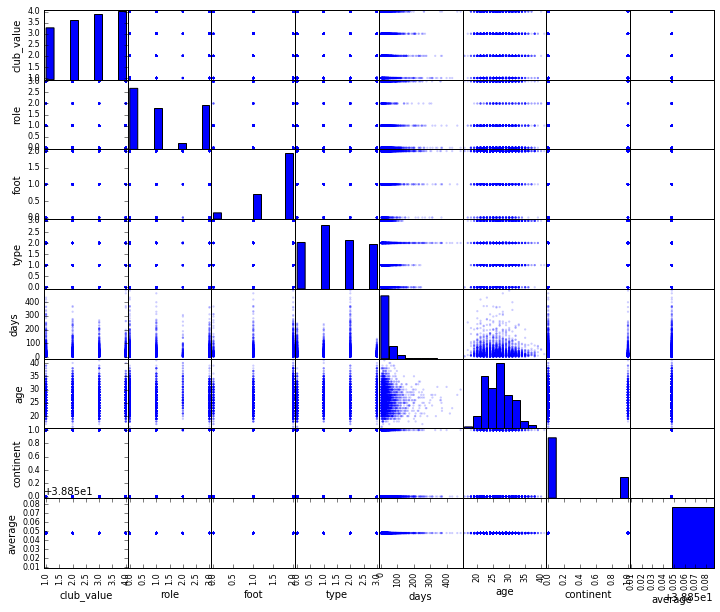

In [853]:
pd.plotting.scatter_matrix(df_scatter_matrix, alpha=0.2,figsize=(12,10));

In [854]:
df = pd.get_dummies(df, columns=["role","foot","continent","type"],sparse=True)
df.head()

,club_value,height,days,age,average,role_0,role_1,role_2,role_3,foot_0,foot_1,foot_2,continent_0,continent_1,type_0,type_1,type_2,type_3
0,4,"1,88",6,25,38.89804,1,0,0,0,0,0,1,1,0,0,0,0,1
1,4,"1,88",42,24,38.89804,1,0,0,0,0,0,1,1,0,0,1,0,0
2,4,"1,88",24,22,38.89804,1,0,0,0,0,0,1,1,0,0,0,1,0
3,4,"1,88",66,21,38.89804,1,0,0,0,0,0,1,1,0,1,0,0,0
4,4,"1,91",12,25,38.89804,1,0,0,0,0,1,0,1,0,0,0,0,1


In [855]:
df['height'] = df['height'].str.replace(',','.').astype(np.float64)
df.head()

,club_value,height,days,age,average,role_0,role_1,role_2,role_3,foot_0,foot_1,foot_2,continent_0,continent_1,type_0,type_1,type_2,type_3
0,4,1.88,6,25,38.89804,1,0,0,0,0,0,1,1,0,0,0,0,1
1,4,1.88,42,24,38.89804,1,0,0,0,0,0,1,1,0,0,1,0,0
2,4,1.88,24,22,38.89804,1,0,0,0,0,0,1,1,0,0,0,1,0
3,4,1.88,66,21,38.89804,1,0,0,0,0,0,1,1,0,1,0,0,0
4,4,1.91,12,25,38.89804,1,0,0,0,0,1,0,1,0,0,0,0,1


## Our goal is to predict the number of days out 

In [856]:
df_train, df_test = split(df, train_size=0.7, 
                            random_state=12121)
df_train.head()

,club_value,height,days,age,average,role_0,role_1,role_2,role_3,foot_0,foot_1,foot_2,continent_0,continent_1,type_0,type_1,type_2,type_3
2556,1,1.79,10,30,38.89804,1,0,0,0,0,1,0,1,0,0,0,0,1
704,4,1.72,25,26,38.89804,1,0,0,0,0,0,1,0,1,0,1,0,0
3294,2,1.80,6,21,38.89804,1,0,0,0,0,0,1,1,0,1,0,0,0
86,4,1.87,34,28,38.89804,0,0,0,1,0,0,1,1,0,0,0,0,1
2310,2,1.81,138,28,38.89804,1,0,0,0,0,1,0,1,0,0,0,1,0


In [857]:
corr = df_train.corr()
corr.style.background_gradient(cmap='coolwarm')

,club_value,height,days,age,average,role_0,role_1,role_2,role_3,foot_0,foot_1,foot_2,continent_0,continent_1,type_0,type_1,type_2,type_3
club_value,1,-0.00324759,-0.122695,-0.0268883,1.5412e-16,0.0622943,-0.0347245,-0.0141035,-0.0275326,-0.0320278,0.0478658,-0.0282089,-0.0257066,0.0257066,-0.0271854,0.113927,-0.115335,0.0191473
height,-0.00324759,1,0.030342,0.0800144,1.14792e-13,0.188636,-0.133208,0.260468,-0.189302,-0.0435777,-0.0694326,0.0877419,0.076715,-0.076715,-0.011906,-0.045655,0.0657625,-0.00490854
days,-0.122695,0.030342,1,-0.0414642,-6.30889e-17,-0.0229179,0.00223497,0.0237128,0.0122297,0.0287533,-0.0230463,0.00664834,0.0317999,-0.0317999,0.000219612,-0.0893039,0.237602,-0.147864
age,-0.0268883,0.0800144,-0.0414642,1,-5.09013e-16,0.0687706,-0.0406167,0.122215,-0.0887058,-0.020605,-0.0674028,0.0738924,-0.0743067,0.0743067,-0.188704,0.0734411,-0.046218,0.157476
average,1.5412e-16,1.14792e-13,-6.30889e-17,-5.09013e-16,1,5.98445e-16,5.32663e-17,-8.73045e-17,-2.56573e-16,-1.01952e-15,7.96491e-17,-4.70038e-16,2.3018e-16,-2.3018e-16,-4.98045e-16,-2.05473e-16,4.25769e-17,-2.19514e-16
role_0,0.0622943,0.188636,-0.0229179,0.0687706,5.98445e-16,1,-0.494212,-0.171747,-0.527389,-0.0915881,0.145206,-0.0884721,0.0773975,-0.0773975,-0.0281798,-0.0102525,-0.0248503,0.0664687
role_1,-0.0347245,-0.133208,0.00223497,-0.0406167,5.32663e-17,-0.494212,1,-0.124264,-0.38158,0.0689692,-0.0432012,0.00462546,-0.104963,0.104963,-0.00702057,0.0569188,-0.0242427,-0.032135
role_2,-0.0141035,0.260468,0.0237128,0.122215,-8.73045e-17,-0.171747,-0.124264,1,-0.132606,-0.0286676,-0.0201495,0.0337946,0.0611249,-0.0611249,-0.0193852,-0.0105589,0.0622475,-0.0334995
role_3,-0.0275326,-0.189302,0.0122297,-0.0887058,-2.56573e-16,-0.527389,-0.38158,-0.132606,1,0.0447801,-0.106427,0.0764666,-0.00870901,0.00870901,0.0458506,-0.0395469,0.0231132,-0.026048
foot_0,-0.0320278,-0.0435777,0.0287533,-0.020605,-1.01952e-15,-0.0915881,0.0689692,-0.0286676,0.0447801,1,-0.152825,-0.376802,0.00927095,-0.00927095,0.00835198,0.0206237,-0.022601,-0.00826878


## Linear regression model

In [858]:
X = df_train.drop(['days','average'], axis=1)
y = df_train[['days']]

In [859]:
X.head()

,club_value,height,age,role_0,role_1,role_2,role_3,foot_0,foot_1,foot_2,continent_0,continent_1,type_0,type_1,type_2,type_3
2556,1,1.79,30,1,0,0,0,0,1,0,1,0,0,0,0,1
704,4,1.72,26,1,0,0,0,0,0,1,0,1,0,1,0,0
3294,2,1.80,21,1,0,0,0,0,0,1,1,0,1,0,0,0
86,4,1.87,28,0,0,0,1,0,0,1,1,0,0,0,0,1
2310,2,1.81,28,1,0,0,0,0,1,0,1,0,0,0,1,0


In [860]:
injury_lm = LinearRegression(fit_intercept=True).fit(X, y)

In [861]:
print (injury_lm.coef_)

[[ -3.8319806   10.50116709  -0.17871123  -0.53018838   0.05541379
    0.72466327  -0.24988868   3.95349072  -2.74888112  -1.2046096
    1.22091854  -1.22091854  -0.65326678  -5.18870844  18.21933814
  -12.37736292]]


#### Apply the model

In [862]:
df_train['days pred.'] = injury_lm.predict(X)
df_train.head()

,club_value,height,days,age,average,role_0,role_1,role_2,role_3,foot_0,foot_1,foot_2,continent_0,continent_1,type_0,type_1,type_2,type_3,days pred.
2556,1,1.79,10,30,38.89804,1,0,0,0,0,1,0,1,0,0,0,0,1,30.152478
704,4,1.72,25,26,38.89804,1,0,0,0,0,0,1,0,1,0,1,0,0,24.927388
3294,2,1.80,6,21,38.89804,1,0,0,0,0,0,1,1,0,1,0,0,0,41.302278
86,4,1.87,34,28,38.89804,0,0,0,1,0,0,1,1,0,0,0,0,1,21.678623
2310,2,1.81,138,28,38.89804,1,0,0,0,0,1,0,1,0,0,0,1,0,57.484644


In [863]:
rmse_train = np.sqrt(MSE(df_train['days pred.'],
                   df_train['days']))
rmse_train_average = np.sqrt(MSE(df_train['average'],
                   df_train['days']))
print ("RMSE train = {:.2f}".format(rmse_train))
print ("RMSE train average = {:.2f}".format(rmse_train_average))
X_test = df_test.drop(['days','average'], axis=1)
df_test['days pred_test.'] = injury_lm.predict(X_test)
rmse_test = np.sqrt(MSE(df_test['days pred_test.'],
                   df_test['days']))
rmse_test_average = np.sqrt(MSE(df_test['average'],
                   df_test['days']))
print ("RMSE = {:.2f}".format(rmse_test))
print ("RMSE test average= {:.2f}".format(rmse_test_average))

RMSE train = 43.97
RMSE train average = 45.76
RMSE = 45.00
RMSE test average= 47.43


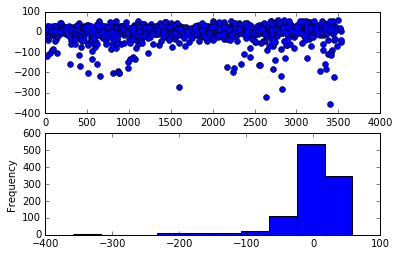

In [864]:
residuals = df_test['days pred_test.'] - df_test['days']
plt.figure()
plt.subplot(211)
plt.plot(residuals, linestyle=' ', marker='o')
plt.subplot(212)
residuals.plot(kind='hist', bins=10)

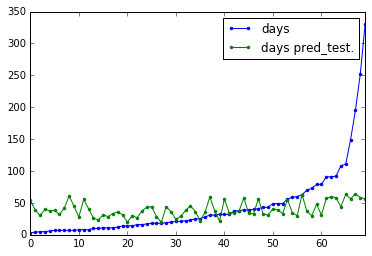

In [865]:
df_test_sample = df_test.sample(70)
df_test_sample = df_test_sample.sort_values('days').reset_index(drop=True)

df_test_sample.days.plot(style='.-')
df_test_sample['days pred_test.'].plot(style='.-')
plt.legend()

********************************************************************************************************

### Linear Regression summury different Parameter

In [866]:
tuples = []
i=0
for t in open('Final-playerTmp.txt'):
    i=i+1
    if i == 5087:
        tuples.append(eval(t[1:-1]))
    else:
        tuples.append(eval(t[1:-2]))
df_sum = pd.DataFrame(tuples)
df_sum.columns = ["id", "name", "club","club_value","birth","weight","height","country","role","foot","transfers","injuries"]

In [867]:
def injurie_age(season,birth):
    return datetime.datetime.strptime(season, '%Y-%m-%d').year - datetime.datetime.strptime(birth, '%Y-%m-%d').year
def club_to_category(value):
    if 0 < value <=  60 :
        return 1
    if 60 < value <= 135 :
        return 2
    if 135 < value <= 315 :
        return 3
    else :
        return 4
def fix_foot(foot):
    if foot in ["right","left","both"] :
        return foot
    return "both"
def convert_country_to_continent(country):
    try:
        country_code = pc.country_name_to_country_alpha2(country, cn_name_format="default")
        continent_name = pc.country_alpha2_to_continent_code(country_code)
        return continent_name
    except:
        if(country in ["England","Kosovo","Wales","Scotland","Northern Ireland","Bosnia-Herzegovina","North Macedonia"]):
            return "EU"
        if(country in ["DR Congo","Cote d'Ivoire","The Gambia"]):
            return "AF"
        if(country =="Korea, South"):
            return "AS"
        if(country == "Curacao"):
            return "SA"
        return "ROW"
def convert_to_main_role(value):
    try:
        return value.split("-")[0]
    except:
        return None
def merge_continent(continent):
        if(continent in ["EU","NA"]):
            return "EU/NA"
        return "ROW"
def flat_outliers_list(outliers_list):
    outliers_flat_list = []
    for sublist in outliers_list:
        for item in sublist:
            outliers_flat_list.append(int(item))
    return outliers_flat_list

In [868]:
df_sum = df_sum[df_sum['birth'].notnull()]
injuries_list = [injurie[1] for injurie in df_sum['injuries'].sum()]
s = pd.Series(injuries_list).value_counts()
s = df_sum.apply(lambda x: pd.Series(x[11]),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'injurie'
df_sum = df_sum.drop('injuries', axis=1).join(s)
df_sum = df_sum.reset_index(drop=True)
df_sum = df_sum[df_sum['injurie'].notnull()]
df_sum_injurie = pd.DataFrame(df_sum['injurie'].tolist(), index=df_sum.index)
df_sum = df_sum.drop('injurie', axis=1).join(df_sum_injurie)
df_sum = df_sum.rename(index=str, columns={0: "season", 1: "type" , 2 : "days"})
df_sum.season = df_sum.season.apply(lambda x : '20' + x[3:] + '-01-01')
df_sum['age'] = df_sum.apply(lambda x : injurie_age(x['season'], x['birth']), axis=1)
df_sum = df_sum[df_sum['days'] != '?']
df_sum["days"] = pd.to_numeric(df_sum["days"])
df_sum['club_value'] = df_sum['club_value'].apply(lambda x : x.split(",")[0]).astype(int)
df_sum['club_value'] = df_sum['club_value'].apply(lambda x : 1000 if x == 1 else x).astype(int)
df_sum['club_value'] = df_sum['club_value'].apply(club_to_category)
df_sum['foot'] = df_sum['foot'].apply(fix_foot)
df_sum['continent'] = df_sum['country'].apply(convert_country_to_continent)
df_sum['role'] = df_sum['role'].apply(convert_to_main_role)
df_sum = df_sum.drop(["id", "name", "club","birth","weight","country","transfers","season"], axis=1)
df_sum['continent'] = df_sum['continent'].apply(merge_continent)

df_sum = df_sum[df_sum['type'].isin(["Knee Injury","Muscle Injury","Hamstring Injury","Ankle Injury"])]
df_basic = df_sum

In [869]:
injury_samples_list = [["Knee Injury","Muscle Injury","Hamstring Injury","Ankle Injury"]]#,["Knee Injury","Muscle Injury"]]
outliers_map_per_injury = {"Muscle Injury":145,"Knee Injury":550,"Hamstring Injury":250,"Ankle Injury":300}
outliers_possibilities = [False,True]
intercept_possibilities = [True,False]
apply_columns = [["club_value","role","foot","type","age","continent"],["club_value","type"],["club_value"],["age"]]


* Mean 
* With outliers
* Without outliers 
* intercept True
* just with the 2 significant column

In [870]:
RMSE_list = []
for injury_sample_list in injury_samples_list:
    df_sum = df_basic
    df_sum = df_sum[df_sum['type'].isin(injury_sample_list)]
    df_sum = df_sum.reset_index(drop = True)
    df_sum["average"] = df_sum['days'].mean()
    for outlier_possibility in outliers_possibilities:
        if(outlier_possibility):
            outliers_list = []
            for injury in injury_sample_list:
                outliers_list.append(df_sum.index[(df_sum["type"] == injury) & (df_sum["days"] > outliers_map_per_injury.get(injury))].tolist())
            outliers_flat_list = flat_outliers_list(outliers_list)
            df_sum.drop(df_sum.index[outliers_flat_list], inplace=True)
        df_sum_train, df_sum_test = split(df_sum, train_size=0.7,random_state=12121)
        le_cols = []
        for c in ["role","foot","continent","type"]:
            le = LabelEncoder()
            le.fit(df_sum_train[c])
            le_cols.append(le)
            df_sum_train[c] = le.transform(df_sum_train[c])
            df_sum_test[c] = le.transform(df_sum_test[c])
        for apply_column in apply_columns:
            X = df_sum_train[apply_column]
            y = df_sum_train[['days']]
            X_test = df_sum_test[apply_column]
            for intercept in intercept_possibilities:
                print("**************************************")
                print("Injuries type:" ,'-'.join(injury_sample_list))
                print(" without outliers ?: " , outlier_possibility)
                print(" apply column: " , '-'.join(apply_column))
                print(" Intercept :" , intercept)
                injury_lm = LinearRegression(fit_intercept=intercept).fit(X, y)
                df_sum_train['days_pred'] = injury_lm.predict(X)
                rmse = np.sqrt(MSE(df_sum_train['days_pred'],df_sum_train['days']))
                print ("RMSE Train= {:.2f}".format(rmse))
                rmse = np.sqrt(MSE(df_sum_train['average'],df_sum_train['days']))
                print ("RMSE Train average = {:.2f}".format(rmse))
                df_sum_test['days_pred'] = injury_lm.predict(X_test)
                rmse = np.sqrt(MSE(df_sum_test['days_pred'],df_sum_test['days']))
                print ("RMSE Test = {:.2f}".format(rmse))
                rmse = np.sqrt(MSE(df_sum_test['average'],df_sum_test['days']))
                print ("RMSE Test average= {:.2f}".format(rmse))              

**************************************
('Injuries type:', 'Knee Injury-Muscle Injury-Hamstring Injury-Ankle Injury')
(' without outliers ?: ', False)
(' apply column: ', 'club_value-role-foot-type-age-continent')
(' Intercept :', True)
RMSE Train= 56.04
RMSE Train average = 56.89
RMSE Test = 51.50
RMSE Test average= 51.67
**************************************
('Injuries type:', 'Knee Injury-Muscle Injury-Hamstring Injury-Ankle Injury')
(' without outliers ?: ', False)
(' apply column: ', 'club_value-role-foot-type-age-continent')
(' Intercept :', False)
RMSE Train= 57.53
RMSE Train average = 56.89
RMSE Test = 52.10
RMSE Test average= 51.67
**************************************
('Injuries type:', 'Knee Injury-Muscle Injury-Hamstring Injury-Ankle Injury')
(' without outliers ?: ', False)
(' apply column: ', 'club_value-type')
(' Intercept :', True)
RMSE Train= 56.35
RMSE Train average = 56.89
RMSE Test = 51.40
RMSE Test average= 51.67
**************************************
('Injuries t

#### UNTIL HERE LINEAR REGRESSION 

--------------------------------------------------------------------------------------------------------------------------

## KNN REGRESSOR

In [871]:
df_train, df_test = train_test_split(df, train_size=0.7, random_state=42)

In [872]:
X = df_train.drop(['days','average'], axis=1)
y = df_train[['days']]

In [873]:
X.head()

,club_value,height,age,role_0,role_1,role_2,role_3,foot_0,foot_1,foot_2,continent_0,continent_1,type_0,type_1,type_2,type_3
803,3,1.78,35,1,0,0,0,0,0,1,1,0,0,0,1,0
2128,2,1.86,28,1,0,0,0,0,0,1,1,0,1,0,0,0
1646,4,1.83,33,1,0,0,0,0,1,0,1,0,1,0,0,0
1571,2,1.85,21,0,0,0,1,0,0,1,1,0,1,0,0,0
231,4,1.82,26,0,0,0,1,0,0,1,1,0,1,0,0,0


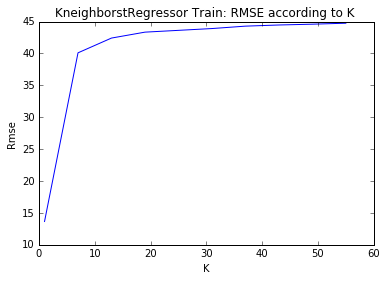

In [874]:
knns=[]
rmse=[]
ks=[]
for k in range(1,61, 6):
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X, y) 
    knns.append(knn)
    ks.append(k)
    rmse.append( np.sqrt(mean_squared_error(y, knn.predict(X))))
plt.plot(ks,rmse)
plt.xlabel('K')
plt.ylabel('Rmse')
plt.title("KneighborstRegressor Train: RMSE according to K ");

#### We can see overfitting for k < 2

In [875]:
X_test = df_test.loc[:, df_test.columns != 'days']
X_test = X_test.loc[:, X_test.columns != 'average']
y_test = df_test[['days']]

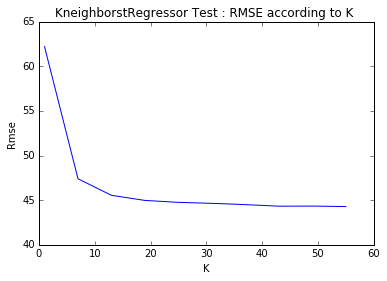

In [876]:
i = -5
ks=[]
rmse = []
score =[]
for knn in knns:
    i = i+6
    rmse.append(np.sqrt(mean_squared_error(y_test, knn.predict(X_test))))
    score.append(r2_score(y_test,knn.predict(X_test)))
    ks.append(i)
plt.plot(ks,rmse)
plt.xlabel('K')
plt.ylabel('Rmse')
plt.title("KneighborstRegressor Test : RMSE according to K ");

#### We will choose k = 31 ( the 6 elements in knns to plot the error)

In [877]:
df_test['days pred_test.'] = knns[5].predict(X_test)

In [878]:
df_test[['days','days pred_test.']].head(10)

,days,days pred_test.
2466,30,31.903226
70,27,24.612903
358,36,25.677419
325,20,28.967742
2314,20,39.741935
298,19,46.516129
979,28,41.580645
1460,54,34.129032
291,52,36.580645
2191,9,27.129032


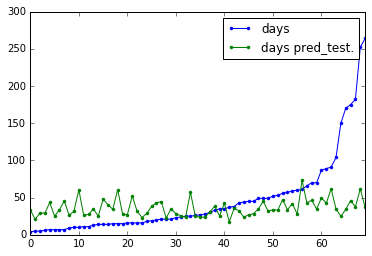

In [879]:
df_test_sample = df_test.sample(70)
df_test_sample = df_test_sample.sort_values('days').reset_index(drop=True)

df_test_sample.days.plot(style='.-')
df_test_sample['days pred_test.'].plot(style='.-')
plt.legend();

#### let's check with normalize and distance

In [880]:
df_train, df_test = train_test_split(df, train_size=0.7, random_state=42)

In [881]:
scalers =np.array( [['Standard', StandardScaler], 
                    ['MinMax', MinMaxScaler], 
                    ['QuantileTransformer', QuantileTransformer],
                    ['Normalizer' , Normalizer ],
                    ['RobustScaler', RobustScaler],
                   ])
metrics = np.array(['euclidean','manhattan','chebyshev','cosine'])
                    
weights = ['uniform','distance']

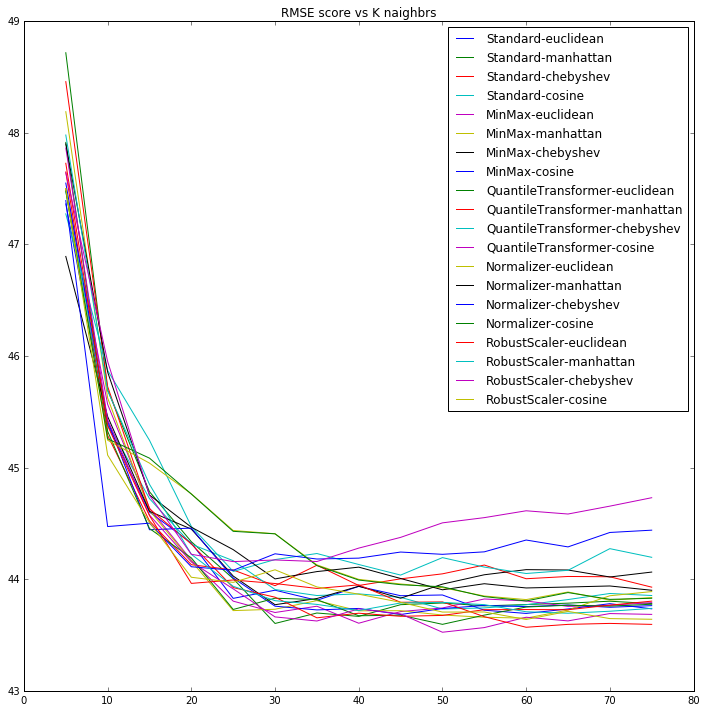

In [882]:
plt.figure(figsize=(12, 12))
f1s = []
ks = []
legend = []
for [scaler_name, scaler_func] in scalers:
    scaler = scaler_func()
    scaler.fit(df_train.drop(['days','average'], axis=1))
    X = scaler.transform(df_train.drop(['days','average'], axis=1))
    y = df_train['days']
    X_test = scaler.transform(df_test.drop(['days','average'], axis=1))
    y_test = df_test['days']
    for metric in metrics:
        f1s = []
        ks = []
        for k in range(5,80, 5):
            knn = KNeighborsRegressor(n_neighbors=k,metric=metric)    
            knn.fit(X, y)
            y_test_pred = knn.predict(X_test)
            ks.append(k)
            f1s.append(np.sqrt(mean_squared_error(y_test,y_test_pred)))
        plt.plot(ks, f1s)
        legend.append(scaler_name+'-'+metric)
plt.legend(legend, loc='upper right')
plt.title('RMSE score vs K naighbrs')


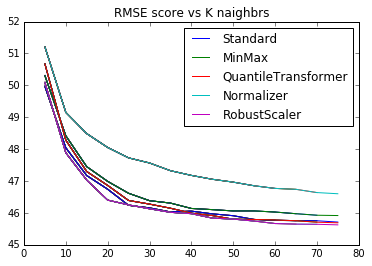

In [883]:
f1s = []
ks = []
for [scaler_name, scaler_func] in scalers:
    scaler = scaler_func()
    scaler.fit(df_train.drop(['days','average'], axis=1))
    X = scaler.transform(df_train.drop(['days','average'], axis=1))
    y = df_train['days']
    X_test = scaler.transform(df_test.drop(['days','average'], axis=1))
    y_test = df_test['days']
    f1s = []
    ks = []
    for k in range(5,80, 5):
        knn = KNeighborsRegressor(n_neighbors=k,weights='distance')    
        knn.fit(X, y)
        y_test_pred = knn.predict(X_test)
        ks.append(k)
        f1s.append(np.sqrt(mean_squared_error(y_test,y_test_pred)))
        plt.plot(ks, f1s)
    
plt.legend(scalers[:,0], loc='upper right')
plt.title('RMSE score vs K naighbrs')

#### Until here the best model is KNN regressor with k = 60 and weight uniform and getdummies for variable with MSE of 43.5 .. bad result ...

#### Let's check with cross validation to see if another train set get better result 

In [884]:
def show_results(scores):
    scores_ = (-scores)#**0.5
    print(np.sqrt(scores_))
    print("Mean:", np.sqrt(scores_.mean()))
    #print("Std:", scores_.std()) 
    return np.sqrt(scores_.mean())

In [885]:
df_train, df_test = train_test_split(df, train_size=0.7, random_state=42)

In [886]:
injury_lm = LinearRegression()

In [887]:
X_train = df_train.drop(['days','average'], axis=1)
y_train = df_train[['days']]

In [888]:
scores = cross_val_score(injury_lm, X_train, y_train, 
                         scoring='neg_mean_squared_error' ,#'mean_squared_error',
                         cv=8)

show_results(scores)

[40.43681751 35.09731212 45.77640621 43.71506731 48.01370412 36.80982121
 50.345767   54.47559214]
('Mean:', 44.771655540119724)


44.771655540119724

#### KNN regressor with cross validation

In [889]:
df_train, df_test = train_test_split(df, train_size=0.7, random_state=42)

In [890]:
scaler = RobustScaler()
scaler.fit(df_train.drop(['days','average'], axis=1))
X_train = scaler.transform(df_train.drop(['days','average'], axis=1))
y_train = df_train['days']

In [891]:
knn = KNeighborsRegressor(n_neighbors=100)    

In [892]:
scores = cross_val_score(knn, X_train, y_train, 
                         scoring='neg_mean_squared_error' ,#'mean_squared_error',
                         cv=8)

show_results(scores)

[40.61453411 34.66944948 45.77848496 43.92780876 47.94243967 36.08820161
 51.63115573 55.21416947]
('Mean:', 44.988956624278735)


44.988956624278735

## Decision Tree Regressor

In [893]:
df_train, df_test = split(df, train_size=0.7, random_state=42)

In [894]:
dt = DecisionTreeRegressor(max_depth=3)

In [895]:
X_train = df_train.drop(['days','average'], axis=1)
y_train = df_train[['days']]
X_test = df_test.drop(['days','average'], axis=1)
y_test = df_test[['days']]


In [896]:
y_train_pred = dt.fit(X_train, y_train).predict(X_train)
df_train['pred'] = y_train_pred

y_test_pred = dt.fit(X_train, y_train).predict(X_test)
df_test['pred'] = y_test_pred

df_train=df_train.reset_index(drop=True)
df_test=df_test.reset_index(drop=True)

In [897]:
print('MSE train:',np.sqrt(mean_squared_error(y_train, y_train_pred)),
    'MSE test:',np.sqrt(mean_squared_error(y_test, y_test_pred)))

('MSE train:', 44.38802665092501, 'MSE test:', 43.45434195743784)


In [898]:
scores = cross_val_score(dt, X_train, y_train, 
                         scoring='neg_mean_squared_error' ,#'mean_squared_error',
                         cv=5)

show_results(scores)

[39.37998753 43.73635227 46.18431373 45.40540568 53.91495975]
('Mean:', 45.967633205095005)


45.967633205095005

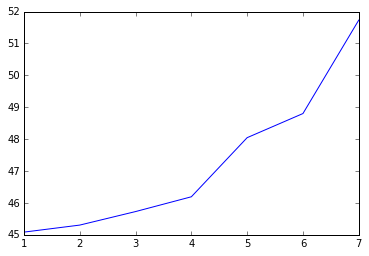

In [899]:
mean = []
depth = []
for d in range(1,8):
    dt = DecisionTreeRegressor(max_depth=d)
    scores = cross_val_score(dt, X_train, y_train, 
                         scoring='neg_mean_squared_error' ,#'mean_squared_error',
                         cv=10)
    depth.append(d)
    mean.append(np.sqrt((-scores).mean()))
plt.plot(depth, mean);


## Result according to different methods/models

#### We try 3 models:
* LinearRegression 
    * RMSE ~= <font color = red>45 days</font> (average RMSE ~= 47.5 days)
* KNNRegressor
    * RMSE ~= <font color = red>43.6 days</font>
* TreeRegressor
    * RMSE ~= <font color = red>43.5 days </font>

*For each Model I used different way , I play with the parameters:*

* LinearRegression : ( Intercept Parameter ( True,False), outliers(True,False ) , Apply column for train and test ..)
    * Intercept = False better than Intercept = True 
    * Outliers = False better : with Outliers , RMSE ~=<font color = red> 51 days</font> without , RMSE ~= <font color = red>45 days</font>
    * Apply column better with all the data than one column or two ( For our data) : only "age",without outliers RMSE ~=<font color = red>48 days</font>
* KNNRegressor : I "played" with parameters : k , distance and metric and normalize
    * k = 60 , distance='uniforme' , metric="euclidian" ,normalize="RobustScaler" RMSE ~= <font color = red>43.6 days</font>
* TreeRegressor : I" played with the depth of the Tree.
    * depth = 3 RMSE ~= <font color = red>43.5 days </font>
* For each one I calculate with cross validation.


*All the result was close to the basic model ( average ) , So I decided to modify the data :*

* Remove all the injury that have more than 125 days 
    * RMSE ~= <font color = red>25 days</font> according to all the models ( average model RMSE ~= 27 days )  
* Put all the injury that have more than 125 days to have now 125 days
    * RMSE ~= <font color = red>30 days</font> according to all the models
* make train only with data under 125 days and test with all the data under and above 125 days 
    * RMSE (in train ) ~= 25 days but in test RMSE ~= <font color = red>51 days ...</font>

another method that I used is to not use Label encoder but GetDummies 
  * I get better result with getDummies about 2 days lower 